# Common

In [230]:
import sys
from pathlib import Path
root_proj = Path("/Users/yk/Documents/Projects/Pre-PhD")

if str(root_proj/"src") not in sys.path:
    sys.path.append(str(root_proj/"src"))

# Read Data

In [231]:
import pandas as pd

year = 2023
file_name = root_proj / f"DATA_SYSTEM_LIDL/DTS_LIDL_{year}.csv"
dts1 = pd.read_csv(file_name, sep=";")
dts1["Date_utc"] = pd.to_datetime(
    dts1["Date"],
    format="%d/%m/%Y %H:%M"
)-pd.Timedelta(hours=1) 

dts1['offset'] = (dts1["Date_utc"].dt.tz_localize("UTC").dt.tz_convert("Europe/Paris").dt.tz_localize(None) - dts1["Date_utc"]).dt.total_seconds()//3600
dts1 

,Date,PV,EV,Date_utc,offset
0,1/01/2023 1:00,0.0,0.12,2023-01-01 00:00:00,1.0
1,1/01/2023 1:15,0.0,0.08,2023-01-01 00:15:00,1.0
2,1/01/2023 1:30,0.0,0.08,2023-01-01 00:30:00,1.0
3,1/01/2023 1:45,0.0,0.12,2023-01-01 00:45:00,1.0
4,1/01/2023 2:00,0.0,2.12,2023-01-01 01:00:00,1.0
...,...,...,...,...,...
34940,31/12/2023 0:00,0.0,7.12,2023-12-30 23:00:00,1.0
34941,31/12/2023 0:15,0.0,7.16,2023-12-30 23:15:00,1.0
34942,31/12/2023 0:30,0.0,7.16,2023-12-30 23:30:00,1.0
34943,31/12/2023 0:45,0.0,7.12,2023-12-30 23:45:00,1.0


In [232]:
temp = pd.read_csv(root_proj / f"DATA_SYSTEM_LIDL/Temperature/orly_{year}_hourly_weather.csv", sep=",")
temp["Date"]= pd.to_datetime(temp["time"], utc=True)
temp["Date_utc"] = pd.to_datetime(temp["time"], utc=True).dt.tz_localize(None)
temp['offset'] = (temp["Date"].dt.tz_convert("Europe/Paris").dt.tz_localize(None) - temp["Date_utc"]).dt.total_seconds()//3600
temp_wanted = temp[temp["Date_utc"] <= "2023-12-31 00:00:00"]
temp_wanted = temp_wanted.set_index("Date_utc")
dts_t = temp_wanted.resample("15min").ffill()
dts_t = dts_t.reset_index()
dts_t = dts_t[["Date_utc","offset",'temp']]
dts_t

,Date_utc,offset,temp
0,2023-01-01 00:00:00,1.0,14.2
1,2023-01-01 00:15:00,1.0,14.2
2,2023-01-01 00:30:00,1.0,14.2
3,2023-01-01 00:45:00,1.0,14.2
4,2023-01-01 01:00:00,1.0,14.4
...,...,...,...
34940,2023-12-30 23:00:00,1.0,9.4
34941,2023-12-30 23:15:00,1.0,9.4
34942,2023-12-30 23:30:00,1.0,9.4
34943,2023-12-30 23:45:00,1.0,9.4


In [233]:
dts = dts1.merge(dts_t[['Date_utc','temp']], on="Date_utc")
dts = dts[['Date_utc','offset','PV','EV','temp']]
dts = dts.rename(columns={"Date_utc":"Date"})
dts

,Date,offset,PV,EV,temp
0,2023-01-01 00:00:00,1.0,0.0,0.12,14.2
1,2023-01-01 00:15:00,1.0,0.0,0.08,14.2
2,2023-01-01 00:30:00,1.0,0.0,0.08,14.2
3,2023-01-01 00:45:00,1.0,0.0,0.12,14.2
4,2023-01-01 01:00:00,1.0,0.0,2.12,14.4
...,...,...,...,...,...
34940,2023-12-30 23:00:00,1.0,0.0,7.12,9.4
34941,2023-12-30 23:15:00,1.0,0.0,7.16,9.4
34942,2023-12-30 23:30:00,1.0,0.0,7.16,9.4
34943,2023-12-30 23:45:00,1.0,0.0,7.12,9.4


# Features

In [234]:
import numpy as np

In [235]:
# dts['minute'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.minute
dts['hour'] = dts['Date'].dt.hour
dts['dayofyear'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.dayofyear
dts['month'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.month
dts['dayofweek'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.dayofweek
dts['hour_sin'] = np.sin(2*np.pi*dts['hour']/24)
dts['hour_cos'] = np.cos(2*np.pi*dts['hour']/24)
dts['doy_sin'] = np.sin(2*np.pi*dts['dayofyear']/365)
dts['doy_cos'] = np.cos(2*np.pi*dts['dayofyear']/365)
dts['dow_sin'] = np.sin(2*np.pi*dts['dayofweek']/7)
dts['dow_cos'] = np.cos(2*np.pi*dts['dayofweek']/7)

In [236]:
dts

,Date,offset,PV,EV,temp,hour,dayofyear,month,dayofweek,hour_sin,hour_cos,doy_sin,doy_cos,dow_sin,dow_cos
0,2023-01-01 00:00:00,1.0,0.0,0.12,14.2,0,1,1,6,0.000000,1.000000,1.721336e-02,0.999852,-0.781831,0.623490
1,2023-01-01 00:15:00,1.0,0.0,0.08,14.2,0,1,1,6,0.000000,1.000000,1.721336e-02,0.999852,-0.781831,0.623490
2,2023-01-01 00:30:00,1.0,0.0,0.08,14.2,0,1,1,6,0.000000,1.000000,1.721336e-02,0.999852,-0.781831,0.623490
3,2023-01-01 00:45:00,1.0,0.0,0.12,14.2,0,1,1,6,0.000000,1.000000,1.721336e-02,0.999852,-0.781831,0.623490
4,2023-01-01 01:00:00,1.0,0.0,2.12,14.4,1,1,1,6,0.258819,0.965926,1.721336e-02,0.999852,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34940,2023-12-30 23:00:00,1.0,0.0,7.12,9.4,23,364,12,5,-0.258819,0.965926,-1.721336e-02,0.999852,-0.974928,-0.222521
34941,2023-12-30 23:15:00,1.0,0.0,7.16,9.4,23,364,12,5,-0.258819,0.965926,-1.721336e-02,0.999852,-0.974928,-0.222521
34942,2023-12-30 23:30:00,1.0,0.0,7.16,9.4,23,364,12,5,-0.258819,0.965926,-1.721336e-02,0.999852,-0.974928,-0.222521
34943,2023-12-30 23:45:00,1.0,0.0,7.12,9.4,23,364,12,5,-0.258819,0.965926,-1.721336e-02,0.999852,-0.974928,-0.222521


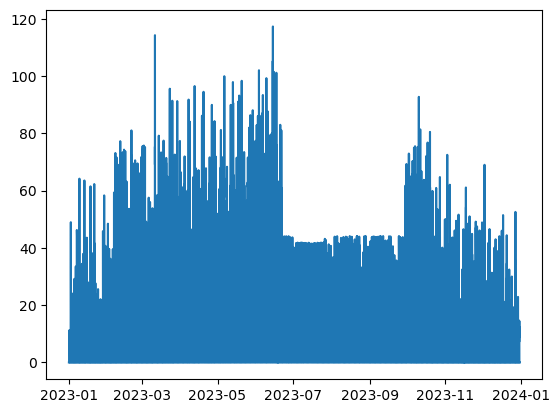

In [237]:
import matplotlib.pyplot as plt

plt.plot(dts['Date'], dts['PV'])
plt.show()

# Create blank

In [238]:
cut = {
    2022: ('2022-04-01 01:00:00', '2022-05-05 01:00:00'),
    2023: ('2023-06-22 01:00:00', '2023-09-29 01:00:00')
}
initial, final = cut[year]
# initial = '2023-06-22 01:00:00'
# final = '2023-09-29 01:00:00'
# initial = dts.index[dts['Date'] == pd.Timestamp('2022-04-01 01:00:00', tz='Europe/Paris').tz_convert("UTC").tz_localize(None)][0]
# final = dts.index[dts['Date'] == pd.Timestamp('2022-05-05 01:00:00', tz='Europe/Paris').tz_convert("UTC").tz_localize(None)][0]


mask = (dts['Date'] >= initial) & (dts['Date'] <= final)
dts['pv_power'] = dts['PV']
dts.loc[mask, 'pv_power'] = np.nan

# build data

In [239]:
features = [
    # 'hour', 'dayofyear', 'month', 'dayofweek', 
    'hour_sin', 'hour_cos', 'doy_sin', 'doy_cos', 'dow_sin', 'dow_cos',
    "temp" # , "offset"
]

train_mask = (
    dts["pv_power"].notna() &   # y 不能有 NaN
    (dts["PV"] > 0)             # 只在白天学
)
# train_mask = dts["PV"].notna()

X = dts.loc[train_mask, features]
y = dts.loc[train_mask, "PV"]


# Create model

In [240]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=5,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)

In [ ]:
weights = y / y.max()
weights = weights.clip(lower=0.3)

model.fit(X, y, sample_weight=weights)
# model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Fill the blank

In [242]:
missing_mask = dts["pv_power"].isna()

X_missing = dts.loc[missing_mask, features]

dts.loc[missing_mask, "PV_filled"] = model.predict(X_missing)


# Merge the result

In [243]:
dts["PV_final"] = dts["PV"]
dts.loc[missing_mask, "PV_final"] = dts.loc[missing_mask, "PV_filled"] + dts['PV'].mean()*3
dts.loc[dts['PV'].eq(0), "PV_final"] = 0

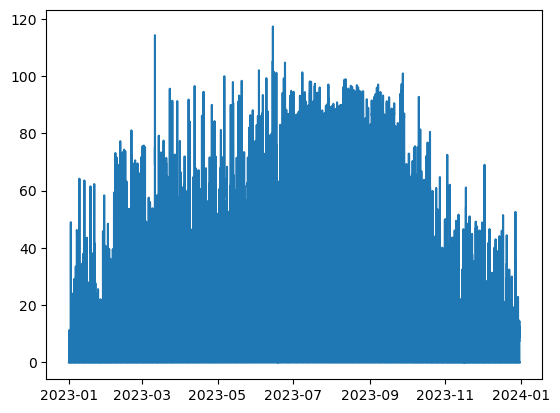

In [244]:
plt.plot(dts['Date'], dts['PV_final'])
plt.show()

# Use rate

$$
\alpha(t) = \frac{PV(t)}{PV_{clear}(t)}
$$

where
- $PV_{clear}(t)$ is PV theory in sunny day
- $\alpha(t) \in [0, 1.2]$

In [251]:
day_mask = dts["PV"] > 0
train_mask = (dts['Date'] < initial) | (dts['Date'] > final)

In [256]:
# 每个月 × 每个 15min 时刻的 95% 分位
clear_proxy = (
    dts.loc[day_mask]
      .groupby(["month", "hour"])["PV"]
      .quantile(0.95)
)

dts["PV_clear"] = [
    clear_proxy.get((m, h), np.nan)
    for m, h in zip(dts["month"], dts["hour"])
]
# 安全处理
dts["PV_clear"] = dts["PV_clear"].ffill()
dts["PV_clear"] = dts["PV_clear"].clip(lower=0)


In [259]:
dts["alpha"] = dts["PV"] / dts["PV_clear"]

# 合理物理范围
dts["alpha"] = dts["alpha"].clip(lower=0, upper=1.3)


In [ ]:
X = dts.loc[train_mask&day_mask, features].astype(float)
y = dts.loc[train_mask&day_mask, "alpha"].astype(float)

In [ ]:
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=5,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)

model.fit(X, y)

In [ ]:
# 对缺失段预测 α，并还原 PV

missing_mask = df["PV"].isna()

df.loc[missing_mask, "alpha_pred"] = model.predict(
    df.loc[missing_mask, feature_cols]
)

# 物理裁剪
df["alpha_pred"] = df["alpha_pred"].clip(0, 1.2)

# 还原功率
df.loc[missing_mask, "PV_pred"] = (
    df.loc[missing_mask, "alpha_pred"] *
    df.loc[missing_mask, "PV_clear"]
)


In [ ]:
# 夜间强制为0
night_mask = (df["hour"] < 6) | (df["hour"] > 18)
df.loc[night_mask, "PV_pred"] = 0.0
